In [1]:
import logging
import numpy as np
from scipy.stats import norm
from IPython.display import display

# %matplotlib inline
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from regions import CircleSkyRegion
import matplotlib.pyplot as plt
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.datasets import MapDatasetOnOff
from gammapy.estimators import ExcessMapEstimator
from gammapy.makers import RingBackgroundMaker, SafeMaskMaker
from gammapy.data import DataStore

from astroquery.simbad import Simbad
log = logging.getLogger(__name__)

In [2]:
!export GAMMAPY_DATA=gammapy-data/1.0

In [84]:
source_pos = SkyCoord(83.6287500,22.0123611,unit='deg')

map_deg = 2.5
config = AnalysisConfig()
# Select observations - 2.5 degrees from the source position
config.observations.datastore = "/raid/romulus/swong/mydl3/testing"
datastore = DataStore.from_dir("/raid/romulus/swong/mydl3/testing")
config.observations.obs_cone = {
    "frame": "icrs",
    "lon": source_pos.ra,
    "lat": source_pos.dec,
    "radius": map_deg * u.deg,
}

config.datasets.type = "3d"
config.datasets.geom.wcs.skydir = {
    "lon": source_pos.ra,
    "lat": source_pos.dec,
    "frame": "icrs",
}  # The WCS geometry - centered on MSH 15-52
config.datasets.geom.wcs.width = {"width": "3 deg", "height": "3 deg"}
config.datasets.geom.wcs.binsize = "0.02 deg"

# Cutout size (for the run-wise event selection)
config.datasets.geom.selection.offset_max = map_deg * u.deg

# We now fix the energy axis for the counts map - (the reconstructed energy binning)
config.datasets.geom.axes.energy.min = "0.2 TeV"
config.datasets.geom.axes.energy.max = "10 TeV"
config.datasets.geom.axes.energy.nbins = 10

# We need to extract the ring for each observation separately, hence, no stacking at this stage
config.datasets.stack = False

# config.datasets.safe_mask.methods = "aeff-max"

print(config)

AnalysisConfig

    general:
        log: {level: info, filename: null, filemode: null, format: null, datefmt: null}
        outdir: .
        n_jobs: 1
        datasets_file: null
        models_file: null
    observations:
        datastore: /raid/romulus/swong/mydl3/testing
        obs_ids: []
        obs_file: null
        obs_cone: {frame: icrs, lon: 83.62875 deg, lat: 22.0123611 deg, radius: 2.5 deg}
        obs_time: {start: null, stop: null}
        required_irf: [aeff, edisp, psf, bkg]
    datasets:
        type: 3d
        stack: false
        geom:
            wcs:
                skydir: {frame: icrs, lon: 83.62875 deg, lat: 22.0123611 deg}
                binsize: 0.02 deg
                width: {width: 3.0 deg, height: 3.0 deg}
                binsize_irf: 0.2 deg
            selection: {offset_max: 2.5 deg}
            axes:
                energy: {min: 0.2 TeV, max: 10.0 TeV, nbins: 10}
                energy_true: {min: 0.5 TeV, max: 20.0 TeV, nbins: 16}
        map_s

In [85]:
analysis = Analysis(config)

# for this specific case,w e do not need fine bins in true energy
analysis.config.datasets.geom.axes.energy_true = (
    analysis.config.datasets.geom.axes.energy
)

# `First get the required observations
analysis.get_observations()

print(analysis.config)

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}
Fetching observations.
Observations selected: 4 out of 4.
Number of selected observations: 4


AnalysisConfig

    general:
        log: {level: INFO, filename: null, filemode: null, format: null, datefmt: null}
        outdir: .
        n_jobs: 1
        datasets_file: null
        models_file: null
    observations:
        datastore: /raid/romulus/swong/mydl3/testing
        obs_ids: []
        obs_file: null
        obs_cone: {frame: icrs, lon: 83.62875 deg, lat: 22.0123611 deg, radius: 2.5 deg}
        obs_time: {start: null, stop: null}
        required_irf: [aeff, edisp, psf, bkg]
    datasets:
        type: 3d
        stack: false
        geom:
            wcs:
                skydir: {frame: icrs, lon: 83.62875 deg, lat: 22.0123611 deg}
                binsize: 0.02 deg
                width: {width: 3.0 deg, height: 3.0 deg}
                binsize_irf: 0.2 deg
            selection: {offset_max: 2.5 deg}
            axes:
                energy: {min: 0.2 TeV, max: 10.0 TeV, nbins: 10}
                energy_true: {min: 0.2 TeV, max: 10.0 TeV, nbins: 10}
        map_s

In [86]:
obs = analysis.get_observations()

Fetching observations.
Observations selected: 4 out of 4.
Number of selected observations: 4


In [87]:
analysis.observations.ids

['64080', '64081', '64082', '64083']

In [88]:
analysis.get_datasets()

Creating reference dataset and makers.
Creating the background Maker.
No background maker set. Check configuration.
Start the data reduction loop.
Computing dataset for observation 64080
Running MapDatasetMaker
Running SafeMaskMaker
Computing dataset for observation 64081
Running MapDatasetMaker
Running SafeMaskMaker
Computing dataset for observation 64082
Running MapDatasetMaker
Running SafeMaskMaker
Computing dataset for observation 64083
Running MapDatasetMaker
Running SafeMaskMaker


In [89]:
simbad = Simbad()
simbad.reset_votable_fields()
simbad.add_votable_fields('ra', 'dec', "flux(B)", "flux(V)", "jp11")
simbad.remove_votable_fields('coordinates')

srcs_tab = simbad.query_region(source_pos, radius=1.5*u.deg)
srcs_tab = srcs_tab[srcs_tab["FLUX_B"]<8]
srcs_tab = srcs_tab[srcs_tab["FLUX_V"]!=np.ma.masked]
srcs_tab

MAIN_ID,RA,DEC,FLUX_B,FLUX_V,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",mag,mag,
object,str13,str13,float32,float32,int32
HD 37013B,05 36 26.0940,+21 59 35.399,7.56,7.03,1
HD 37013A,05 36 26.3842,+21 59 35.208,7.93,7.41,1
HD 36879,05 35 40.5264,+21 24 11.719,7.69,7.58,1
HD 36160,05 30 43.3479,+22 27 44.117,7.471,6.291,1
* zet Tau,05 37 38.6854,+21 08 33.158,2.84,3.03,1
HD 37439,05 39 27.1151,+21 45 46.627,6.5,6.43,1


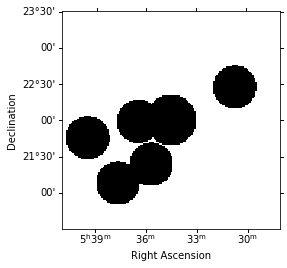

In [90]:
# get the geom that we use
geom = analysis.datasets[0].counts.geom
energy_axis = analysis.datasets[0].counts.geom.axes["energy"]
geom_image = geom.to_image().to_cube([energy_axis.squash()])

safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)
# Make the exclusion mask
regions = CircleSkyRegion(center=source_pos, radius=0.35 * u.deg)
all_ex = [regions]
stars = []
for star in srcs_tab:
    pos = SkyCoord(star["RA"], star["DEC"], frame="fk5", unit=(u.hourangle, u.deg))
    star = CircleSkyRegion(center=pos, radius=0.3 * u.deg)
    stars.append(star)
    all_ex.append(star)

exclusion_mask = ~geom_image.region_mask(all_ex)
exclusion_mask.sum_over_axes().plot()
plt.show()

In [91]:
ring_maker = RingBackgroundMaker(
    r_in="0.3 deg", width="0.1 deg", exclusion_mask=exclusion_mask
)

In [92]:
energy_axis_true = analysis.datasets[0].exposure.geom.axes["energy_true"]
stacked_on_off = MapDatasetOnOff.create(
    geom=geom_image, energy_axis_true=energy_axis_true, name="stacked"
)
for dataset in analysis.datasets:
    # Ring extracting makes sense only for 2D analysis
    dataset_on_off = ring_maker.run(dataset.to_image())
    stacked_on_off.stack(dataset_on_off)

In [95]:
stacked_on_off.info_dict()

{'name': 'stacked',
 'counts': 3151,
 'excess': 800.42578125,
 'sqrt_ts': 15.662193037309837,
 'background': 2350.57421875,
 'npred': 2355.010873145526,
 'npred_background': 2355.010873145526,
 'npred_signal': nan,
 'exposure_min': <Quantity 11616184. m2 s>,
 'exposure_max': <Quantity 6.40448192e+08 m2 s>,
 'livetime': <Quantity 4047.60504987 s>,
 'ontime': <Quantity 4808. s>,
 'counts_rate': <Quantity 0.77848505 1 / s>,
 'background_rate': <Quantity 0.58073211 1 / s>,
 'excess_rate': <Quantity 0.19775294 1 / s>,
 'n_bins': 22500,
 'n_fit_bins': 22500,
 'stat_type': 'wstat',
 'stat_sum': 14743.690496654184,
 'counts_off': 900297,
 'acceptance': 22500.0,
 'acceptance_off': 8617759.0,
 'alpha': 0.002610887633636594}

In [93]:
spectrum_dataset = stacked_on_off.to_spectrum_dataset(CircleSkyRegion(center=source_pos, radius=(np.sqrt(0.008) * u.deg)),containment_correction=True)
spectrum_dataset.info_dict()

{'name': 'syUtXgDh',
 'counts': 544,
 'excess': 533.8438110351562,
 'sqrt_ts': 56.012614891120094,
 'background': 10.15616512298584,
 'npred': 12.751378573837405,
 'npred_background': 12.751378573837405,
 'npred_signal': nan,
 'exposure_min': <Quantity 1.10841992e+08 m2 s>,
 'exposure_max': <Quantity 5.31460224e+08 m2 s>,
 'livetime': <Quantity 4047.60504987 s>,
 'ontime': <Quantity 4808. s>,
 'counts_rate': <Quantity 0.13440046 1 / s>,
 'background_rate': <Quantity 0.00250918 1 / s>,
 'excess_rate': <Quantity 0.13189128 1 / s>,
 'n_bins': 1,
 'n_fit_bins': 1,
 'stat_type': 'wstat',
 'stat_sum': 3137.413026940929,
 'counts_off': 2079,
 'acceptance': 1.0,
 'acceptance_off': 204.7032470703125,
 'alpha': 0.004885120317339897}

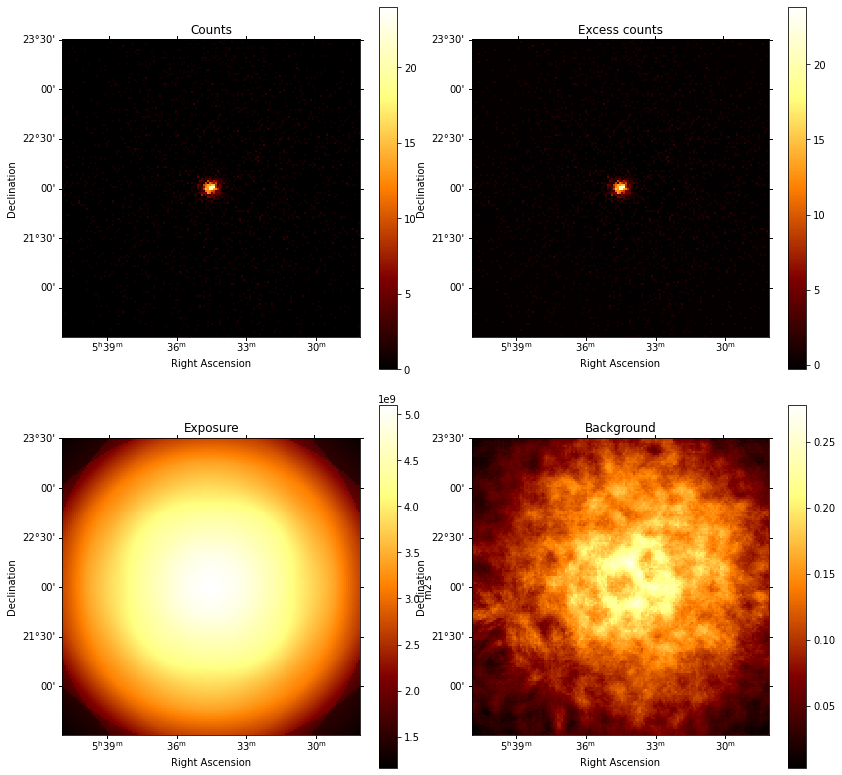

In [14]:
stacked_on_off.peek(figsize=(14,14))

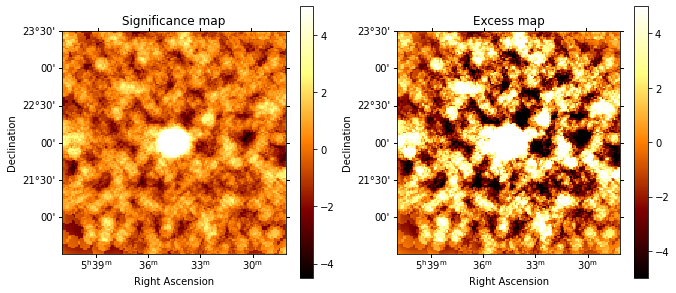

In [27]:
# Using a convolution radius of 0.04 degrees
estimator = ExcessMapEstimator(0.089 * u.deg, selection_optional=[])
lima_maps = estimator.run(stacked_on_off)

significance_map = lima_maps["sqrt_ts"]
excess_map = lima_maps["npred_excess"]

# We can plot the excess and significance maps
fig, (ax1, ax2) = plt.subplots(
    figsize=(11, 5), subplot_kw={"projection": lima_maps.geom.wcs}, ncols=2
)

ax1.set_title("Significance map")
significance_map.plot(ax=ax1, add_cbar=True, vmax = 5)

# for star in srcs_tab:
    
ax2.set_title("Excess map")
excess_map.plot(ax=ax2, add_cbar=True, vmin=-5, vmax = 5)
#fig.savefig("3C120_Maps.png")
plt.show()

In [28]:
print(f'Significance: {"%.2f" % np.nanmax(significance_map.data[np.isfinite(significance_map.data)])} sigma')

Significance: 56.49 sigma


Fit results: mu = -0.03, std = 1.00


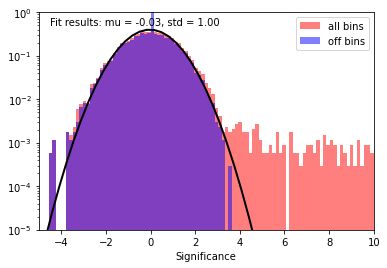

In [29]:
# create a 2D mask for the images
significance_map_off = significance_map * exclusion_mask
significance_all = significance_map.data[np.isfinite(significance_map.data)]
significance_off = significance_map_off.data[np.isfinite(significance_map_off.data)]

fig, ax = plt.subplots()
ax.hist(
    significance_all,
    density=True,
    alpha=0.5,
    color="red",
    label="all bins",
    bins=np.linspace(-5,10,100),
)

ax.hist(
    significance_off,
    density=True,
    alpha=0.5,
    color="blue",
    label="off bins",
    bins=np.linspace(-5,10,100),
)

# Now, fit the off distribution with a Gaussian
mu, std = norm.fit(significance_off)
x = np.linspace(-8, 8, 50)
p = norm.pdf(x, mu, std)
ax.plot(x, p, lw=2, color="black")
ax.legend()
ax.set_xlabel("Significance")
ax.set_yscale("log")
ax.set_ylim(1e-5, 1)
xmin, xmax = np.min(significance_all), np.max(significance_all)
ax.set_xlim(-5, 10)

print(f"Fit results: mu = {mu:.2f}, std = {std:.2f}")
ax.text(-4.5, 0.5, f"Fit results: mu = {mu:.2f}, std = {std:.2f}")
#plt.savefig("3C120_RBM.png")
plt.show()